# Stock Sector prediction using XGBoost
PCA provides a low dimensional representation of the correlations between price changes in stock.
As was explained in the previous notebook, these correlations correspond to the fact that the prices of similar stocks react similarly to news about changes in the market environment.

In this notebook you will use boosted trees to predict the sector of test stocks. You will use as features the the coefficients of the 20 top eigenvectors as a representation of the stock.

You will not know whether your predicions are correct. However, by splitting the training set into training and validation you would be able to estimate the error that your classifier will incur on the test set.

In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read PCA parameters

In [2]:
D=pickle.load(open('data/PCA_true.pickle','rb'))
col=D['columns']
eigvec=D['eigvec']
eigval=D['eigval']

### Sanity check
The following scatterplot should be very similar to the scatter plot you produced in the first notebook for eigvec 1, eigvec 2 (indexing starts with 1)

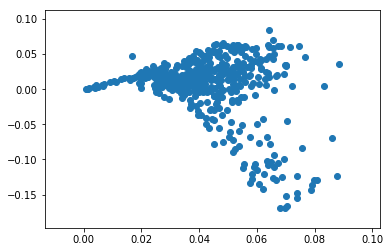

In [3]:
scatter(eigvec[:,0],eigvec[:,1])

## compute features

The features that we use are the coefficients of the top 20 eigenvectors.

Those can be read directly from the eigenvectors matrix.

In [4]:
#Taking the top 20 features(Eigen vectors)
features=eigvec[:,:20]
features.shape

(481, 20)

##  Compute labels (sectors)

In [5]:
TickerInfo=pd.read_csv('data/tickerInfo.tsv',sep='\t')
print(TickerInfo.shape)
TickerInfo.head()

(505, 5)


,Unnamed: 0,Ticker,Name,Sector,SECTOR_ID
0,0,MMM,3M|3M Company,Industrials,INDS
1,1,ABT,Abbott Laboratories,Health Care,HC
2,2,ABBV,AbbVie Inc.,Health Care,HC
3,3,ACN,Accenture plc,Information Technology,IT
4,4,ATVI,Activision Blizzard,Information Technology,IT


### Creating necessary dictionaries

The Sectors dictionary below has the Sector name mapped to the sector ID. Using the Sectors dictionary below, create a dictionary mapping of the sector ID to indices incrementally as follows:

```
{
    'CD': 0,
    'CS': 1,
    'EN': 2,
    'FIN': 3,
    'HC': 4,
    'INDS': 5,
    'IT': 6,
    'MAT': 7,
    'RE': 8,
    'TS': 9,
    'UTIL': 10
}
```

In addition to this, you will need to create one more dictionary mapping index number to the sector name:
```
{
    0: 'Consumer Discretionary',
    1: 'Consumer Staples',
    2: 'Energy',
    3: 'Financials',
    4: 'Health Care',
    5: 'Industrials',
    6: 'Information Technology',
    7: 'Materials',
    8: 'Real Estate',
    9: 'Telecommunication Services',
    10: 'Utilities'
}
 ```

In [6]:
Sectors={'Consumer Discretionary':'CD',
 'Consumer Staples':'CS',
 'Energy':'EN',
 'Financials':'FIN',
 'Health Care':'HC',
 'Industrials':'INDS',
 'Information Technology':'IT',
 'Materials':'MAT',
 'Real Estate':'RE',
 'Telecommunication Services':'TS',
 'Utilities':'UTIL'}


### get_sectors_dicts()
Create two dictionaries relatng number and sectors.

**<font color="magenta" size=2>Input</font>**
<br>
A dictionary **Sectors** as given in the previous cell.

**<font color="blue" size=2>Output</font>**
<br>
Return two dictionaries **sector2number** and **number2sectorName** as mentioned in the description.

In [7]:
def get_sector_dicts(Sectors):
    sector2number={}
    i=0;
    for name,short in sorted(Sectors.items()):
        sector2number[short]=i
        i+=1
    sectorID2sectorName = {key:value for (value, key) in Sectors.items()}
    number2sectorID = {key:value for (value, key) in sector2number.items()}
    number2sectorName = {i:sectorID2sectorName[number2sectorID[i]] for i in number2sectorID}
    return sector2number, number2sectorName


In [8]:
sector2number, number2sectorName = get_sector_dicts(Sectors)

### Construct the training and testing datasets

In [9]:
labels=[]
feature_vectors=[]
feature_vectors_test=[]
test_nos = []
for i in range(len(col)):
    c=col[i]
    if 'train' in c:
        ticker=c[6:-2]
        answer=list(TickerInfo[TickerInfo.Ticker==ticker]['SECTOR_ID'])
        if len(answer)==1:
            sector_no=sector2number[answer[0]]
            labels.append(sector_no)
            feature_vectors.append(features[i,:])
        else:
            print('error: could not find sector for ticker:',ticker)
    if 'test' in c:
        test_nos.append(c[5:-2])
        feature_vectors_test.append(features[i,:])

In [10]:
#verify lengths
len(labels),len(feature_vectors), len(test_nos),len(feature_vectors_test)

(392, 392, 89, 89)

## Placing the data into numpy arrays as expected by xgboost

In [11]:
X=np.array(feature_vectors)
y=np.array(labels)
X_test = np.array(feature_vectors_test)
# y_test = np.array(test_nos)
X.shape, y.shape, X_test.shape#, y_test.shape

((392, 20), (392,), (89, 20))

In [12]:
#Splitting the labeled data (X,y) into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=6)
X_train.shape, X_valid.shape

((274, 20), (118, 20))

In [13]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=11

num_round = 100

## Generating scores using XGBoost

The function <font color="blue">get_margin_scores</font> is used to predict the sector for each of the given samples.

**<font color="magenta" size=2>Input</font>**
<br>
1. **Training set** (X_train)
2. **Validation set** (X_valid)
3. **Training labels** (y_train)
4. **XGBoost Parameter List** (param)


**<font color="blue" size=2>Output</font>**
<br>
Return the following:
1. **y_pred_valid**: The raw output scores for the validation set


**Note**:
1. Round all raw scores to **three** decimal places
2. Remember to use **verbose_eval = False** while training and **ntree_limit=bst.best_ntree_limit** and **output_margin=True** while predicting
3. Remember to provide the **num_round** parameter while training and do not change it. We have currently set it to 100 (Refer to the previous cell). Not providing the parameter or changing it could produce different results.

In [14]:
def round_rows(val):
    return round(val, 3)
    
def get_margin_scores(X_train, X_valid, y_train, param):
    #
    # YOUR CODE HERE
    #
    dTrain = xgb.DMatrix(X_train, label=y_train)
    dValid = xgb.DMatrix(X_valid)
   
    # Training model.    
    boostTree = xgb.train(param, dTrain, num_boost_round = num_round, verbose_eval=False)
    
    # Predicting validation data.
    y_pred_valid = boostTree.predict(dValid, ntree_limit=boostTree.best_ntree_limit, output_margin=True)
    
    # Vectorizing method to apply to matrix elements.
    myfunc_vec = np.vectorize(round_rows)
    return myfunc_vec(y_pred_valid)

In [15]:
y_pred_valid = get_margin_scores(X_train, X_valid, y_train, param)
print(y_pred_valid.shape) # 118 validation tests, 11 classes per test.
print(y_pred_valid[0:3])

(118, 11)
[[-0.347 -3.01  -1.557  3.031 -3.336 -4.426 -1.297 -1.754  6.04  -3.06
  -2.764]
 [ 0.274 -1.584 -2.223 -2.199 -3.256 -2.909  2.392 -0.374 -1.715 -2.847
  -2.764]
 [-3.213 -0.942 -1.678  4.148 -3.025 -1.184 -4.03  -0.91  -3.222 -2.962
  -2.764]]


In [16]:
assert y_pred_valid.shape == (118, 11), "Incorrect shape"
assert type(y_pred_valid) == numpy.ndarray, "Incorrect type"

In [17]:
# Hidden Tests Here
#If rounding off is the problem, give them 6 points out of 8
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [18]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [19]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


## Computing Top1 and Top5 predictions

Using the margin scores generated, calculate top1 and top5 predictions for the given data:

**top1**: Find the highest scoring prediction for each example in the validation set

**top5**: Find the top 5 highest scoring predictions in descending order for each example in the validation set (Highest to lowest)

**<font color="magenta" size=2>Input</font>**

1. **Validation Output Scores** (y_pred_valid)

**<font color="blue" size=2>Output</font>**

1. **predictions_valid**: The highest scoring prediction for each example in the the validation set
2. **predictions_topn**: The top 5 highest scoring prodictions for each example in the validation set

**<font color="magenta" size=2>Sample input</font>**
1. **y_pred_valid**: [[-0.3, 1.2, 0.3, 0.5, -0.4, 0.0, 0.01, 1.0, -1.3, 0.2, -1.2], [0.4, -0.5, 1.3, -0.2, 0.6, -2.2, -0.8, 1.9, 0.9, -0.2, -1.7]]

**<font color="blue" size=2>Sample output</font>** 
1. **predictions_valid**: [1, 7]
2. **predictions_top5**: [[1,  7,  3,  2,  9], [ 7,  2,  8,  4,  0]]

In [20]:
def get_predictions(y_pred_valid):
    top1 = []
    top5 = []
    numClasses = param['num_class']
    
    for row in y_pred_valid:       
        # Note that if you use x[argsort(x)], you get the array X sorted,
        # so you just need to return its top 5 elememnts on reverse order.
        topClasses = row.argsort()  
        top1.append(topClasses[numClasses - 1])
        top5.append(list(reversed(topClasses[numClasses - 5 : numClasses])))
    
    return np.array(top1), np.array(top5)


In [21]:
predictions_valid, predictions_top5 = get_predictions(y_pred_valid)
print(predictions_top5[0:3])
print(y_pred_valid[0:3])

[[8 3 0 6 2]
 [6 0 7 1 8]
 [3 7 1 5 2]]
[[-0.347 -3.01  -1.557  3.031 -3.336 -4.426 -1.297 -1.754  6.04  -3.06
  -2.764]
 [ 0.274 -1.584 -2.223 -2.199 -3.256 -2.909  2.392 -0.374 -1.715 -2.847
  -2.764]
 [-3.213 -0.942 -1.678  4.148 -3.025 -1.184 -4.03  -0.91  -3.222 -2.962
  -2.764]]


In [22]:
assert predictions_valid.shape == (118,), "Incorrect shape"
assert predictions_top5.shape == (118, 5), "Incorrect shape"
assert type(predictions_valid) == numpy.ndarray, "Incorrect type"
assert type(predictions_top5) == numpy.ndarray, "Incorrect type"

In [23]:
# Check if you get the correct top4 for the first 3 elements.
predictions_top5_first3=\
    array([[8, 3, 0, 6, 2],
           [6, 0, 7, 1, 8],
           [3, 7, 1, 5, 2]])
assert (predictions_top5_first3 == predictions_top5[:3]).all(), "Incorrect predictions"

In [24]:
# Hidden Tests Here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [25]:
# Hidden Tests Here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


## Estimating accuracy
We will now compute the accuracies of the predictions, where
* **Top 1** is the fraction of examples on which the correct sector has the highest score.
* **Top 2** is the fraction of examples on which the correct sector has the highest **or** second highest score.
* ...
* **Top 5** is the fraction of examples on which the correct sector has one of the top 5 scores.

These scores are all based on the training set. In principle, the errors on the test set can be different. However, if we assume that the test and train set are generated by the same distribution, then these are reasonable estimate of the accuracy we expect to get.

In [26]:
acc = 0
for i in range(5):
    acc += sum(predictions_top5[:, i]==y_valid)
    print("Top ", i+1, ": \t", acc/len(y_valid))

Top  1 : 	 0.7203389830508474
Top  2 : 	 0.864406779661017
Top  3 : 	 0.9152542372881356
Top  4 : 	 0.9322033898305084
Top  5 : 	 0.9491525423728814


## Generating the confusion matrix

What is a confusion matrix?
This is a useful link that explains this: https://en.wikipedia.org/wiki/Confusion_matrix#Example

We will now be using the top 2 values of **predictions_top5** to produce the confusion matrix. We will create the confusion matrix by considering the correct section $j$ and the two sections with the highest scores $i_1,i_2$ where $score(i_1) > score(i_2)$ are the two sectors with the two highest scores.

* A prediction is *correct* if $j=i_1$. correct examples are ignored.
* The predicion $i_2$ is confused with $i_1$ if $j=i_2$
* If $j \neq i_1$ and $j \neq i_2$ then the example is ignored. 

### Examples

We consider two scenarios where the possible categories are `(0,1,2,3)`

#### Scenario 1

**<font color="magenta" size=2>Sample Input</font>**<br>
y_label = 3<br>
top2_predictions = [2, 3]

**<font color="blue" size=2>Output</font>**<br>
confusion_matrix:<br>
[0 0 0 0]<br>
[0 0 0 0]<br>
[0 0 0 1]<br>
[0 0 0 0]<br>
**Explanation**:  
The first example has top two predictions: (2, 3) and the label 3. So we add 1 to the position (2,3).

#### Scenario 2

**<font color="magenta" size=2>Sample Input</font>**<br>
Say we have 7 sample prediction values<br>
y_label = [3, 2, 3, 1, 0, 2, 2]<br>
top2_predictions = [[2, 3], [0, 3], [2, 3], [1, 2], [3, 0], [2, 0], [3, 2]]

**<font color="blue" size=2>Output</font>**<br>
confusion_matrix:<br>
[0 0 0 0]<br>
[0 0 0 0]<br>
[0 0 0 2]<br>
[1 0 1 0]<br>

**Explanation**:  
The second example has 7 sample predictions: 
1. In two scenarios 2 is predicted in place of 3 and the cell (2,3) is incremented twice.
2. In two other scenarios we have a case where the second prediction is right. The corresponding cells {(3,0) and (3,2)} are incremented once each.
3. In two scenarios, the first element is the correct prediction. Thus no cell is incremented.
4. In one scenario, neither of the top 2 predictions is correct. Thus no cell is incremented.

**Note**: y_label is the same as y_valid here.

In [27]:
def get_confusion_matrix(predictions_top5, y_valid):
    # Confusion matrix 11x11.
    confusion_matrix = np.zeros((param['num_class'], param['num_class']), dtype=numpy.int64)
    for predRow, y in zip(predictions_top5, y_valid):
        i0 = predRow[0]
        i1 = predRow[1]
        if (i0 == y or i1 != y):
            # If we are sure that we are correct or incorrect, ignore it.
            continue
        
        # Increase the cell showing the class that where we had confusion.
        confusion_matrix[i0][y] = confusion_matrix[i0][y] + 1
    
    return confusion_matrix


In [28]:
confusion_matrix = get_confusion_matrix(predictions_top5, y_valid)

In [29]:
assert confusion_matrix.shape == (11, 11), "Incorrect shape"
assert type(confusion_matrix) == numpy.ndarray, "Incorrect type"
assert type(confusion_matrix[0][0]) == numpy.int64, "Incorrect type"

In [30]:
# Hidden Tests Here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [31]:
for i in range(confusion_matrix.shape[0]):
    print("%30s" % number2sectorName[i], "\t", confusion_matrix[i, :])

        Consumer Discretionary 	 [0 1 0 0 0 0 1 0 0 0 0]
              Consumer Staples 	 [0 0 0 0 0 0 0 0 0 0 0]
                        Energy 	 [0 0 0 0 0 0 0 0 0 0 0]
                    Financials 	 [0 0 0 0 0 0 1 0 0 0 0]
                   Health Care 	 [0 0 0 0 0 0 2 0 0 0 0]
                   Industrials 	 [2 0 0 0 0 0 1 4 0 0 0]
        Information Technology 	 [2 0 0 0 0 0 0 0 0 0 0]
                     Materials 	 [0 0 0 0 0 1 0 0 0 0 0]
                   Real Estate 	 [1 0 0 0 1 0 0 0 0 0 0]
    Telecommunication Services 	 [0 0 0 0 0 0 0 0 0 0 0]
                     Utilities 	 [0 0 0 0 0 0 0 0 0 0 0]


## Interpretation of confusion matrix

Based on the confusion matrix generated, answer the following questions.

Categories:
```
    0) Consumer Discretionary
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

### instructions for answering the questions in this section
1. Each question has two parts: **ans** and **num_scen**
    1. **ans**: A list with numbers corresponding to the different categories. For example, if the answer is Consumer Discretionary and Consumer Staples, the **ans** should be a **list** containing **single tuple**,i.e. `ans=[(0,1)]` 
    2. **num_scen**: Number of scenarios where the condition in the given question is applicable. For example, if the condition given in the question happens 5 times, the **num_scen** should return **5** as an integer, i.e. `num_scen=5`
2. Type checks have been provided to validate the type of your answer
3. Remember that just the answer for the given matrix should be enough. **You do not have to write a generic function that answers the question for all confusion matrices.**

Examples:
```python
def example_question():
    ans = [(0,1),(2,3)] # sect 0 is confused with sect 1 and sect 2 is confused with sect 3
    num_scen=4 # each of the elements in each pair is confused with the other 4 times.
    return ans,num_scen
```


### Question 1

Which two sectors are most often confused with each other and how many times? 

```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```


In [32]:
def question_1():
    #
    # YOUR CODE HERE
    #
    
    # We need to sum the amount of times that class C
    # was confused with class D and vice-versa. This would give us
    # an matrix, but since we don't need it, we can just store
    # the biggest confusion count.
    num_scen1 = 0
    ans1 = ()
    for i in range(0, param['num_class']):
        for j in range(i, param['num_class']): # The matrix result would be symmetrical.
            conf = confusion_matrix[i][j] + confusion_matrix[j][i]
            if (conf > num_scen1):
                num_scen1 = conf
                ans1 = (i, j)
    
    # Converting types.
    ans1 = [ans1]
    num_scen1 = int(num_scen1)
    return ans1, num_scen1 

In [33]:
ans1, num_scen1 = question_1()
assert type(ans1) == list, "Incorrect type"
assert type(ans1[0]) == tuple, "Incorrect type"
assert type(ans1[0][0]) == int, "Incorrect type"
assert type(num_scen1) == int, "Incorrect type"
print("Most confusions between {0} and {1}, {2} times.".format(
    number2sectorName[ans1[0][0]],
    number2sectorName[ans1[0][1]],
    num_scen1))

Most confusions between Industrials and Materials, 5 times.


In [34]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [35]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Question 2
We call a sector `s` "diffuse" if it is common for an example whose correct label is `s` to have another sector get the highest score while `s` gets the second to largest score.

Which sectors `s` are the most diffuse? For how many examples does diffusion happen?

```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

**Format of answer**

Your answer should have the following format:
```python
def question_2():
    ans2 = <list of numbers>
    num_scen2= <int>
    return ans2,num_scen2
```


In [36]:
def aux_Q2_and_Q3(matrix):
    # We need to count the number of times which
    # each class was confused. This is just the sum of each row
    # after transposing the confusion_matrix. If you see the matrix
    # building method, you will see that the correct label Y was
    # the column parameter.
    total_confusion = np.apply_along_axis(sum, 1, matrix) 
    print(total_confusion)
    num_scenN = 0
    for val in total_confusion:
        if (val > num_scenN):
            num_scenN = val
    
    ansN = []
    for i in range(0, param['num_class']):
        if (total_confusion[i] == num_scenN):
            ansN.append(i)
                      
    # Converting types.
    num_scenN = int(num_scenN)
    
    return ansN, num_scenN

def question_2():
    #
    # YOUR CODE HERE
    #
    
    # We need to count the number of times which
    # each class was confused. This is just the sum of each row
    # after transposing the confusion_matrix. If you see the matrix
    # building method, you will see that the correct label Y was
    # the column parameter.
    return aux_Q2_and_Q3(confusion_matrix.transpose())

In [37]:
ans2, num_scen2 = question_2()
assert type(ans2) == list, "Incorrect type"
assert type(ans2[0]) == int, "Incorrect type"
assert type(num_scen2) == int, "Incorrect type"
print("More diffusion ({0} times) on classes:".format(num_scen2))
for i in ans2:
    print(i, number2sectorName[i])

[5 1 0 0 1 1 5 4 0 0 0]
More diffusion (5 times) on classes:
0 Consumer Discretionary
6 Information Technology


In [38]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [39]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Question 3

Which sector(s) most often identified incorrectly? In other words, the sector recieves the highest score even though the sector with the second highest score is the correct sector. How many times does this happen for each of these sectors?
```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

**Format of answer**

Your answer should have the following format:
```python
def question_3():
    ans3 = <list of numbers>
    num_scen3= <int>
    return ans3,num_scen3
```

In [40]:
def question_3():
    #
    # YOUR CODE HERE
    #
    # It is almost the same thing of question 2, but without
    # transposing the matrix. Lets use the auxiliar method
    # created on Q2.
    
    return aux_Q2_and_Q3(confusion_matrix)

In [41]:
ans3, num_scen3 = question_3()
assert type(ans3) == list, "Incorrect type"
assert type(ans3[0]) == int, "Incorrect type"
assert type(num_scen3) == int, "Incorrect type"
print("Classes most often identified incorrectly ({0} times):".format(num_scen3))
for i in ans3:
    print(i, number2sectorName[i])

[2 0 0 1 2 7 2 1 2 0 0]
Classes most often identified incorrectly (7 times):
5 Industrials


In [42]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [43]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Note for question 4 and 5
**Note**: The next two questions require you to generate a different confusion matrix. Instead of relying on the matrix above, you should write your own code to find the answers to the questions.


### Question 4

Which category/categories is/are never identified? In other words, which category/categories are never predicted as the top prediction?
```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

**Format of answer**

Your answer should have the following format:
```python
def question_4():
    ans4 = <list of numbers>
    return ans4
```

In [44]:
def question_4():
    #
    # YOUR CODE HERE
    #
    # Classes which aren't identified as the top prediction
    # shouldn't appear on the predictions_valid array.
    # We can solve this with like a counting sort.
    count = [0] * param['num_class']
    for i in predictions_valid:
        count[i] = count[i] + 1
        
    ans4 = []    
    for i in range(0, param['num_class']):
        if(count[i] == 0):
            ans4.append(i)
    
    print(count)
    return ans4

In [45]:
ans4 = question_4()
assert type(ans4) == list, "Incorrect type"
assert type(ans4[0]) == int, "Incorrect type"
print("Classes never predicted as the top prediction:")
for i in ans4:
    print(i, number2sectorName[i])

[14, 12, 9, 16, 15, 15, 18, 5, 5, 0, 9]
Classes never predicted as the top prediction:
9 Telecommunication Services


In [46]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Question 5

Which sector(s) is/are most often missed while classifying? In other words, find the sector for which there is the largest number of examples such that the correct label does not appear as the top prediction.


```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

**Format of answer**

Your answer should have the following format:
```python
def question_5():
    ans5 = <list of numbers>
    num_scen5= <int>
    return ans5,num_scen5
```

In [47]:
def question_5():
    #
    # YOUR CODE HERE
    #
    # We would just need to find the smallest ratio for each class
    # if the question was about the class which we have more probability to miss:
    # ratioClass = number of correct predictions on class / number of labels on class.
    # However, it wants the absolute number, so we just need to calculate the delta.

    totalCorrPerClass = [0] * param['num_class']
    totalLabelsPerClass = [0] * param['num_class']
    for pred, y in zip(predictions_valid, y_valid):
        totalLabelsPerClass[y] = totalLabelsPerClass[y] + 1
        if (pred == y):
            totalCorrPerClass[y] = totalCorrPerClass[y] + 1
            
    print(totalCorrPerClass)
    print(totalLabelsPerClass)
    print(sum(totalLabelsPerClass))
    
    # Calculating ratio for each class.
    auxArray = []
    num_scen5 = 0
    delta = 0
    for i in range(0, param['num_class']):
        if (totalLabelsPerClass[i] == 0):
            auxArray.append(0)
            continue
        
        auxArray.append(totalLabelsPerClass[i] - totalCorrPerClass[i])
        if (totalLabelsPerClass[i] != 0 and delta < auxArray[i]):
            delta = auxArray[i]
            num_scen5 = totalCorrPerClass[i]
    
    # Finding classes with smallest ratio.
    ans5 = []
    for i in range(0, param['num_class']):
        if (auxArray[i] == delta):
            ans5.append(i)
    
    return ans5, num_scen5 

In [48]:
ans5, num_scen5 = question_5()
assert type(ans5) == list, "Incorrect type"
assert type(num_scen5) == int, "Incorrect type"

print("The sector(s) which are most often missed while classifying:")
for i in ans5:
    print(i, number2sectorName[i])
    
print("Number of errors found: {0}.".format(num_scen5))

[9, 7, 9, 14, 11, 8, 14, 2, 2, 0, 9]
[17, 10, 9, 14, 12, 15, 22, 6, 2, 1, 10]
118
The sector(s) which are most often missed while classifying:
0 Consumer Discretionary
6 Information Technology
Number of errors found: 9.


In [49]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [50]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


## Test set

List the pair of top two sectors for each test ticker.
Based on your validation results, estimate:
1. ** Accuracy1:** What is the frequency in which the correct sector is the first element in the pair.
2. ** Accuracy2:** What is the frequency in which the correct sector is in the pair.

### Generating test scores

The function <font color="blue">get_margin_scores_test</font> is used to predict the sector for each of the given test samples. Split the input data into train and validation in different ways and average the prediction scores over a number of iterations. You can experiment with the number, but you will need to ensure you remain under the time limit. (This should not take you more than a minute)

We estimate the predictions on the validation and the test set, compute the accuracy on the validation set and report the test predictions with the validation accuracy. In this scenario, we report the average top1 and top2 accuracy.

**<font color="magenta" size=2>Input</font>**
<br>
1. **Input data** (X)
2. **Test data** (X_test)
3. **Input labels** (y)
4. **XGBoost Parameter List** (param)


**<font color="blue" size=2>Output</font>**
<br>
Return the following:
1. **y_pred_test**: The raw output scores for the test set
2. **top1_acc**: Top 1 accuracy on the validation set
3. **top2_acc**: Top 2 accuracy on the validation set


**Note**:
1. You can reuse/call the <font color="blue">get_margin_scores</font> function or rewrite it in this function.
2. Instructions for the <font color="blue">get_margin_scores</font> apply for this too.

In [51]:
def get_acc_valid(X_train, X_valid, y_train, y_valid, param):
    #
    # YOUR CODE HERE
    # 
    # Train the model with train data and get validation predictions.
    y_pred_valid = get_margin_scores(X_train, X_valid, y_train, param)    
    top1_acc = 0
    top2_acc = 0
    top1Index = param['num_class'] - 1
    top2Index = top1Index - 1
    
    # Calculating validation set accuracy.
    for row, correctLabel in zip(y_pred_valid, y_valid):
        # We get an index array sorted by the element indexed by each one.
        orderedPred = row.argsort()  
        if (correctLabel == orderedPred[top1Index]):
            top1_acc = top1_acc + 1  
        elif (correctLabel == orderedPred[top2Index]):
            top2_acc = top2_acc + 1
            
    # Since Top2_acc is the sum of correct first and second predictions,
    # we should sum then at the end.
    top2_acc = top2_acc + top1_acc
      
    # Finally we calculate them.
    totalLabels = len(y_valid)
    top1_acc = top1_acc / totalLabels
    top2_acc = top2_acc / totalLabels
            
    return top1_acc, top2_acc

def get_margin_scores_test(X, X_test, y, param):
    num_validations = 40

    # Lets get an average value of the validation scores.
    top1_acc = 0
    top2_acc = 0
    for i in range(0, num_validations):
        # random_state = None means to use default Random Number generator.
        # We could also use sklearn's KFold method to do a cross-validation
        # instead of create a random split per iteration.
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=None)
        top1, top2 = get_acc_valid(X_train, X_valid, y_train, y_valid, param)
        top1_acc = top1_acc + top1
        top2_acc = top2_acc + top2
        
    top1_acc = top1_acc / num_validations
    top2_acc = top2_acc / num_validations
    
    # After getting a good idea of the accuracy based
    # on our parameters we can predict the test data.
    y_pred_test = get_margin_scores(X, X_test, y, param)    
    return y_pred_test, top1_acc, top2_acc

In [52]:
y_pred_test, top1_acc, top2_acc = get_margin_scores_test(X, X_test, y, param)
print("Top 1 Accuracy: {0}%.".format(top1_acc * 100))
print("Top 2 Accuracy: {0}%.".format(top2_acc * 100))

Top 1 Accuracy: 75.40254237288136%.
Top 2 Accuracy: 87.39406779661017%.


In [53]:
assert type(y_pred_test) == np.ndarray, ""
assert y_pred_test.shape == (89, 11)

In [54]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [55]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [56]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Computing the sector predictions

**Note**: This section is not evaluated. This is merely to see your predictions on the test set and report the top1 and top2 accuracy

In [57]:
predictions1, predictions5 = get_predictions(y_pred_test) #This line will fail if get_predictions is not defined
i=0
print("%10s" % "Test ID", "%30s" % "Top prediction", "%30s" % "Second Top prediction")
for entry in predictions5[:, :2]:
    print("%10s" % test_nos[i], "%30s" % number2sectorName[entry[0]], "%30s" % number2sectorName[entry[1]])
    i += 1
top1_acc_perc = top1_acc*100
top2_acc_perc = top2_acc*100
print("\n\n\nTop 1 accuracy: %s" % top1_acc_perc, "%")
print("\nTop 2 accuracy: %s" % top2_acc_perc, "%")

   Test ID                 Top prediction          Second Top prediction
         0                      Utilities     Telecommunication Services
        10         Information Technology                         Energy
        11                      Materials                    Real Estate
        12                      Materials                    Industrials
        13         Consumer Discretionary                    Real Estate
        14                     Financials         Consumer Discretionary
        15         Consumer Discretionary         Information Technology
        16         Information Technology                    Industrials
        17                         Energy         Consumer Discretionary
        18                         Energy         Consumer Discretionary
        19                         Energy                    Health Care
         1                     Financials               Consumer Staples
        20               Consumer Staples         I

Total 90 points.